# Model 4

This model uses GloVe 6B.100d embeddings and 30,000 vocabulary words.  It also uses 30 neurons and 3 different layers.  Compared to model #3, it reduces the epochs from 50 to 30, raises the learning rate, and uses LSTM.

In [1]:
import numpy as np
import tensorflow as tf

import json
import os
from collections import defaultdict

In [2]:
import os.path  # for manipulation of file path names

import re  # regular expressions

import nltk
from nltk.tokenize import TreebankWordTokenizer

In [18]:
RANDOM_SEED = 9999

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

REMOVE_STOPWORDS = False  # no stopword removal 

EVOCABSIZE = 30000  # specify desired size of pre-defined embedding vocabulary 

In [19]:
# Select the pre-defined embeddings source        
# Define vocabulary size for the language model    
# Create a word_to_embedding_dict for GloVe.6B.50d
embeddings_directory = 'embeddings/gloVe.6B'
filename = 'glove.6B.100d.txt'
embeddings_filename = os.path.join(embeddings_directory, filename)

In [20]:
def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    """
    Read a embeddings txt file. If `with_indexes=True`, 
    we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, 
    otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping 
    from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r', encoding='utf-8') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = \
    load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from embeddings/gloVe.6B\glove.6B.100d.txt
Embedding loaded from disks.


In [21]:
# shows the general structure of the data structures for word embeddings
# This code is modified for our purposes in language modeling 
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

print("Note: for unknown words, the representation is an empty vector,\n"
      "and the index is the last one. The dictionnary has a limit:")
print("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))
word = "worsdfkljsdf"  # a word obviously not in the vocabulary
idx = word_to_index[word] # index for word obviously not in the vocabulary
complete_vocabulary_size = idx 
embd = list(np.array(index_to_embedding[idx], dtype=int)) # "int" compact print
print("    {} --> {} --> {}".format(word, idx, embd))
word = "the"
idx = word_to_index[word]
embd = list(index_to_embedding[idx])  # "int" for compact print only.
print("    {} --> {} --> {}".format(word, idx, embd))

Embedding is of shape: (400001, 100)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.
Note: for unknown words, the representation is an empty vector,
and the index is the last one. The dictionnary has a limit:
    A word --> Index in embedding --> Representation
    worsdfkljsdf --> 400000 --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    the --> 0 --> [-0.038194, -0.24487, 0.72812, -0.39961, 0.083172, 0.043953, -0.39141, 0.3344, -0.57545, 0.087459, 0.28787, -0.06731, 0.30906, -0.26384, -0.13231, -0.20757, 0.33395, -0.33848, -0.31743, -0.48336, 0.1464, -0.37304, 0.34577, 0.052041, 0.44946, -0.46971, 0.02628, -0.54155, -0.15518, -0.14107, -0.039722, 0.28277, 0.14393, 

In [22]:
a_typing_test_sentence = 'The quick brown fox jumps over the lazy dog'

def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding
# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})

# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding = np.append(limited_index_to_embedding, 
    index_to_embedding[index_to_embedding.shape[0] - 1, :].\
        reshape(1,embedding_dim), 
    axis = 0)

# Delete large numpy array to clear some CPU RAM
del index_to_embedding

In [23]:
# Utility function to get file names within a directory
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']   

# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
    more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'] 

    some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
        'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
        'toni','welles','william','wolheim','nikita']

    # start with the initial list and add to it for movie text work 
    stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
        some_proper_nouns_to_remove

In [24]:
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)

In [25]:
dir_name = 'movie-reviews-negative'
    
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for negative movie reviews
# Data will be stored in a list of lists where the each list represents 
# a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

negative_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    negative_documents.append(words)

print('\nNegative Reviews loaded')


Directory: movie-reviews-negative
500 files found

Processing document files under movie-reviews-negative

Negative Reviews loaded


In [26]:
dir_name = 'movie-reviews-positive'  
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list 
# represents a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

positive_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    positive_documents.append(words)
    
print('\nPositive Reviews loaded')


Directory: movie-reviews-positive
500 files found

Processing document files under movie-reviews-positive

Positive Reviews loaded


In [27]:
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

max_review_length: 1052
min_review_length: 22


In [28]:
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [29]:
#----------------------------------------
#Build the Model
#Next block creates the model
#----------------------------------------

#model basics
reset_graph()

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 30  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.01

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [30]:
lstm = [tf.nn.rnn_cell.BasicLSTMCell(num_units = n_neurons,
                                     activation = tf.nn.relu)
         for layer in range(3)]

multi_cell_layer = tf.nn.rnn_cell.MultiRNNCell(lstm)
outputs, states = tf.nn.dynamic_rnn(multi_cell_layer, X, dtype=tf.float32)
top_layer_state = states[-1][1]

logits = tf.layers.dense(top_layer_state, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [31]:
#fit the model
n_epochs = 30
batch_size = 100

train = []
test = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        train.append(acc_train)
        test.append(acc_test)
        print('Epoch -', epoch, 'Train accuracy:', acc_train, 'Test accuracy:', acc_test)

Epoch - 0 Train accuracy: 0.52 Test accuracy: 0.51
Epoch - 1 Train accuracy: 0.58 Test accuracy: 0.505
Epoch - 2 Train accuracy: 0.67 Test accuracy: 0.55
Epoch - 3 Train accuracy: 0.64 Test accuracy: 0.605
Epoch - 4 Train accuracy: 0.74 Test accuracy: 0.63
Epoch - 5 Train accuracy: 0.75 Test accuracy: 0.66
Epoch - 6 Train accuracy: 0.69 Test accuracy: 0.65
Epoch - 7 Train accuracy: 0.69 Test accuracy: 0.625
Epoch - 8 Train accuracy: 0.76 Test accuracy: 0.685
Epoch - 9 Train accuracy: 0.76 Test accuracy: 0.66
Epoch - 10 Train accuracy: 0.5 Test accuracy: 0.53
Epoch - 11 Train accuracy: 0.5 Test accuracy: 0.53
Epoch - 12 Train accuracy: 0.6 Test accuracy: 0.565
Epoch - 13 Train accuracy: 0.5 Test accuracy: 0.53
Epoch - 14 Train accuracy: 0.5 Test accuracy: 0.465
Epoch - 15 Train accuracy: 0.48 Test accuracy: 0.515
Epoch - 16 Train accuracy: 0.57 Test accuracy: 0.5
Epoch - 17 Train accuracy: 0.59 Test accuracy: 0.545
Epoch - 18 Train accuracy: 0.64 Test accuracy: 0.53
Epoch - 19 Train acc

In [32]:
import matplotlib.pyplot as plt

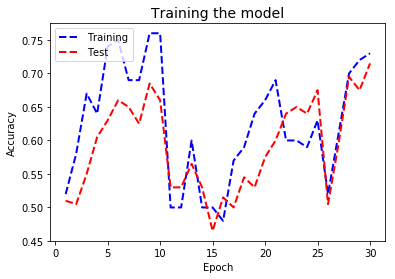

In [39]:
xaxis = []
for x in range(1,31):
    xaxis.append(x)

plt.title("Training the model", fontsize=14)
plt.plot(xaxis, train, "b--", linewidth = 2, markersize = 10, label="Training")
plt.plot(xaxis, test, "r--", linewidth = 2, markersize=10, label="Test")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

This model produced training accuracy of 73% and testing accuracy of 71.5%.  The model is not overfitting, however the accuracy results did not improve with each epoch.